In [ ]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616821 sha256=f8af57a52cc1b9271f7a8c0e3d009d260709f64f8de5d92422146f8278b0765e
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

MLPs không còn quá phức tạo để triển khai như là với mô hình tuyến tính. Sự khác biết chính về mặt khái niệm là giờ đây ta ghép nối nhiều lớp

In [ ]:
"""
Thêm các thư viện cần thiết
"""
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# 5.2.1. Triển khai từ đầu

## 5.2.1.1. Khởi tạo tham số mô hình

Nhớ lại rằng, Fashion-MNIST bao gồm 10 lớp và mỗi hình ảnh bao gồm một lưới $28 \times 28 = 784$ các giá trị pixel thang gray. Như trước đây, ta sẽ bỏ qua cấu trúc không gian giữa các pixel, vì vậy ta có thể coi đây là một tập dữ liệu phân loại với 784 features đầu vào và 10 lớp. Bắt đầu, ta sẽ triển khai MLP với 1 lớp ẩn và 256 hiden node. Cả số lớp và chiều rộng đều có thể điều chỉnh được( được gọi là siêu tham số). Thông thường, chúng ta chọn độ rộng lớp chia hết cho lũy thừa lớn hơn của 2. Điều này hiệu quả về mặt tính toán do cách phân bổ và xử lý bộ nhớ trong phần cứng.

Một lần nữa, chúng ta sẽ biểu diễn các tham số của chúng ta bằng một số tenxơ. Lưu ý rằng đối với mỗi lớp , chúng ta phải theo dõi một ma trận trọng số và một vectơ bias. Như mọi khi, chúng tôi phân bổ bộ nhớ cho độ dốc của tổn thất đối với các tham số này.

Trong code bên dưới, ta sử dụng [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) đẻ tự động đăng ký một thuộc tính lớp làm tham số được theo dõi bởi `autograd`.

In [ ]:
"""
Tạo 1 class để triển khai  MLP từ đầu
Khởi tạo lần lượt các tham số W1,b1, W2,b1
"""
class MLPScratch(d2l.Classifier):
  def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma = 0.01):
    super().__init__()
    self.save_hyperparameters()
    self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens)*sigma)
    self.b1 = nn.Parameter(torch.zeros(num_hiddens))
    self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs)*sigma)
    self.b2 = nn.Parameter(torch.zeros(num_outputs))

## 5.2.1.2. Model

Để đảm bảo rằng, ta biết mọi thứ hoạt động như thế nào thì ta sẽ tự triển khai kích hoạt ReLU thay vì gọi từ hàm tích hợp sẵn.

In [ ]:
"""
Định nghĩa hàm relu
1. Tạo 1 tensor toàn giá trị 0 với size = size của X (đầu vào)
2. So sánh tensor vừa tạo với X và lấy max
3. Ta thu được tensor mới là tensor X với các giá trị âm được gán = 0
"""
def relu(X):
  a = torch.zeros_like(X)
  return torch.max(X, a)

Vì chúng ta không quan tâm đến cấu trúc không gian, chúng ta reshapebiến mỗi hình ảnh hai chiều thành một vectơ phẳng có độ dài num_inputs. Cuối cùng, chúng ta triển khai mô hình của mình chỉ bằng một vài dòng mã. Vì chúng ta sử dụng khung tự động tích hợp sẵn nên đây là tất cả những gì cần thiết.

In [ ]:
"""
Ta triển khai hàm relu vào trong phương thức forward của model
1. Reshape lại X từ 28x28 thành 1x784
2. Tính output của lớp ẩn và kích hoạt relu cho output đó
3. Trả về output của lớp cuối (Output)
"""
@d2l.add_to_class(MLPScratch)
def forward(self, X):
  X = X.reshape((-1, self.num_inputs))
  H = relu(torch.matmul(X,self.W1)+self.b1)
  return torch.matmul(H,self.W2) + self.b2

## 5.2.1.3. Training

May mắn thay, vòng lặp đào tạo cho MLP hoàn toàn giống với hồi quy softmax. Chúng ta xác định mô hình, dữ liệu, huấn luyện viên và cuối cùng gọi phương thức `fit` trên mô hình và dữ liệu.


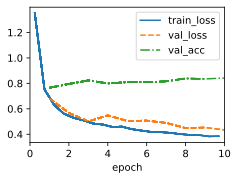

In [ ]:
"""
Training
1. Tạo model với số đầu vào = 784, đầu ra = 10, số node trong lớp ẩn = 256, lr = 0.1
2. Tạo tập dữ liệu với batch_size = 256
3. Khởi tạo trainer với max_epochs = 10
4. Fit model với data
"""
model = MLPScratch(784, 10, 256, 0.1)
data = d2l.FashionMNIST(batch_size = 256)
trainer = d2l.Trainer(max_epochs = 10)
trainer.fit(model, data)

# 5.2.2. Rút gọn

Sau đây, ta sẽ thử sử dụng các API cấp cao, thậm trí MLP còn chính xác hơn.

## 5.2.2.1. Model

So với cách thực hiện ngắn gọn của chúng ta về triển khai hồi quy softmax ( Phần 4.5 ), điểm khác biệt duy nhất là chúng tôi thêm hai lớp được kết nối đầy đủ mà trước đây chúng tôi chỉ thêm một lớp . Đầu tiên là lớp ẩn, thứ hai là lớp đầu ra.

In [ ]:
"""
Ta tạo một class mới MLP trong đó ứng dụng API bậc cao
Chỉ cần khởi tạo self.net tượng trưng cho cả model
1. nn.Flatten(): đập dẹt dát mỏng ảnh 28*28 thành vector 784
2. Tạo lớp ẩn với số node = num_hiddens
3. Cho đi qua hàm kích hoạt ReLU
4. Tạo lớp cuối là output với số node = num_outputs
"""
class MLP(d2l.Classifier):
  def __init__(self, num_outputs, num_hiddens, lr):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                             nn.ReLU(), nn.LazyLinear(num_outputs))

So với trước đây, ta phải xác định forward để mô hình chuyển đổi đầu vào bằng các tham số thành đầu ra. Tuy nhiên, ở đây, ta không phỉa định nghĩa phương thức `forward` vì ở mặc định `forward` đơn giản là gọi `self.net(X)` với X là đầu vào. Được định nghĩa là một chuỗi các phép biến đổi thông qua class `Senquantial`. Ta sẽ xem xét class này sau.

## 5.2.2.2. Training



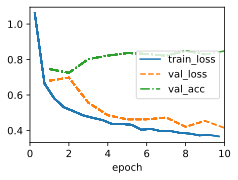

In [ ]:
"""
Tạo model với class mơi và fit data
"""
model = MLP(num_outputs = 10, num_hiddens = 256, lr = 0.1)
trainer.fit(model, data)